<center><h1> How Has Position in the NBA Changed Over Time? </h1></center>

Nowadays, the casual NBA viewer can see that teams are shooting more three-point shots than they ever have. 

In [842]:
import re
import requests
import requests_cache
import pandas as pd
from bs4 import BeautifulSoup
requests_cache.install_cache('bball_ref_cache')
import time
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import manifold
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

In [698]:
def bball_scraper(stat_type, start_year, end_year):
    bball_df = pd.DataFrame()
    url = 'http://www.basketball-reference.com/leagues/NBA_'
    for i in range(end_year-start_year + 1):
            url2 = url + r'%s_' %start_year + r'%s.html' %stat_type
            year = BeautifulSoup(requests.get(url2).content, "lxml")
            columns = year.find('thead').text.split('\n')
            stats = year.find('tbody')
            for figure in stats.find_all('tr', 'thead'):
                figure.decompose()
            data = stats.find_all('tr')
            player = [[td.getText() for td in data[i].findAll('td')] for i in range(len(data))]
            temp = pd.DataFrame(player)
            for index, row in temp.iterrows():
                if row[3] == 'TOT':
                    pname = row[0] 
                    temp = temp[(temp[0] != pname) | (temp[3] == 'TOT')]
            temp['Year'] = start_year
            bball_df = bball_df.append(temp)
            start_year = start_year + 1 
    columns = columns[3:-2]
    columns.append('Year')
    bball_df.columns = columns
    return bball_df

bball_per_game = bball_scraper('per_game', 2001, 2017)
bball_advanced = bball_scraper('advanced', 2001, 2017)
bball_100poss = bball_scraper('per_poss', 2001, 2017)
bball_per_game['MPG'] = bball_per_game['MP']
bball_per_game['MP'] = bball_advanced['MP']

In [833]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
def silhouette(data): 
    fig.set_size_inches(12, 12)
    k = range(2,30)
    score = []
    elbow = []
    for n_clusters in k:
        clusters = KMeans(n_clusters=n_clusters).fit(data)
        cluster_labels = clusters.labels_
        centroid = clusters.cluster_centers_
        euclid = np.min(cdist(data, centroid, 'euclidean'), axis = 1)
        avgss = sum(euclid)/data.shape[0]
        elbow.append(avgss)
        silhouette_avg = silhouette_score(data, cluster_labels)
        score.append(silhouette_avg)
    plt.plot(k, score, 'b*-')
    plt.ylabel("Silhouette Score")
    plt.xlabel("Number of Clusters")
    plt.title("Silhouette Score for KMeans Cluster Analysis")
    plt.show()
    plt.plot(k, elbow, 'b*-')
    plt.ylabel("Average Within-Cluster Sum of Squares")
    plt.xlabel("Number of Clusters")
    plt.title("Elbow Curve for KMeans Cluster Analysis")
    plt.show()
    
def kmeans(data, n_clusters):
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data)
    return cluster_labels

def distance_map(data, clusters):
    adist = np.array(data)
    amax = np.amax(adist)
    adist /= amax
    mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
    results = mds.fit(adist)
    coords = pd.DataFrame(results.embedding_, index = data.index)
    coords['Cluster'] = clusters
    colors = {0:'grey', 1:'red', 2:'blue', 3:'green', 4:'black', 5:'yellow', 6:'purple', 7:'pink', 8:'white'}
    plt.scatter(coords[0], coords[1], marker = 'o', c=coords['Cluster'].apply(lambda x: colors[x]))
    plt.title('2D Representation of Distance Matrix and Color Representation of Clusters')
    plt.show()

In [702]:
bball_100poss2 = bball_100poss.merge(bball_advanced)
bball_100poss2 = bball_100poss2.drop(bball_100poss2[[-5,-10]], axis = 1)
bball_100poss2 = bball_100poss2.apply(lambda x: pd.to_numeric(x, errors='ignore'))
bball_100poss2 = bball_100poss2.loc[bball_100poss2['MP'] > 250]
bball_100poss2.fillna(0, inplace=True)
bball_100poss2 = bball_100poss2.set_index(bball_100poss2['Player'])
bball_100poss2 = bball_100poss2.drop(['Player','Pos','Age','Tm','G','GS','MP', 'TS%', '3PAr', 'FTr', 'PER',
                                      'ORtg','DRtg', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', '',
                                      'FG', '3P', '2P', 'FT', 'TRB', 'TRB%', 'FGA', 'FG%', 'PTS'],axis = 1)
bball_100poss2016 = bball_100poss2.loc[bball_100poss2['Year'] == 2016]
bball_100poss2016.head()

,3PA,3P%,2PA,2P%,FTA,FT%,ORB,DRB,AST,STL,...,TOV,PF,Year,ORB%,DRB%,AST%,STL%,BLK%,TOV%,USG%
Player,,,,,,,,,,,,,,,,,,,,,
Quincy Acy,2.7,0.388,9.0,0.606,3.7,0.735,3.6,6.7,1.5,1.6,...,1.5,5.6,2016,8.1,15.1,4.4,1.6,2.2,10.0,13.1
Steven Adams,0.0,0.000,10.5,0.613,4.8,0.582,5.4,7.7,1.5,1.0,...,2.1,5.5,2016,12.5,16.1,4.3,1.0,3.3,14.1,12.6
Arron Afflalo,5.2,0.382,12.2,0.469,2.8,0.840,0.5,5.3,3.1,0.5,...,1.8,3.1,2016,1.1,11.0,9.9,0.5,0.3,8.7,17.9
Alexis Ajinca,0.1,0.000,18.1,0.478,3.6,0.839,4.3,11.2,1.8,1.1,...,3.1,7.7,2016,9.3,25.9,5.8,1.1,3.4,13.6,20.4
Cole Aldrich,0.0,0.000,14.1,0.596,5.3,0.714,5.4,12.7,3.1,2.9,...,4.0,8.7,2016,11.9,27.1,10.0,2.9,6.7,19.6,18.4


In [703]:
df1 = bball_100poss2016
dist = pdist(df1, 'euclidean')
df_dist = pd.DataFrame(squareform(dist), index = df1.index, columns = df1.index)
df_dist['Festus Ezeli'].sort_values().head()

Player
Festus Ezeli    0.000000
Clint Capela    3.579668
Aron Baynes     3.585576
Willie Reed     5.187558
Henry Sims      6.042845
Name: Festus Ezeli, dtype: float64

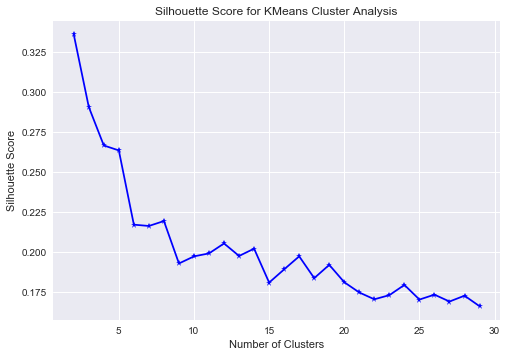

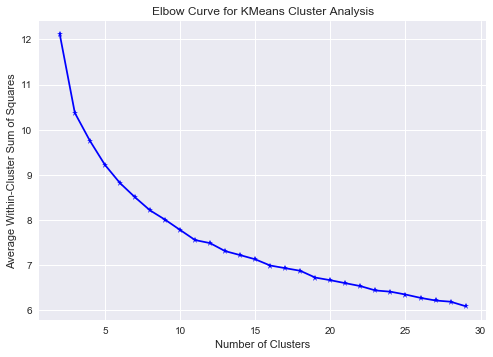

In [730]:
silhouette(bball_100poss2016)

In [731]:
bball_100poss2016['Cluster'] = kmeans(bball_100poss2016, 9)
bball_100poss2016.groupby('Cluster').mean()

,3PA,3P%,2PA,2P%,FTA,FT%,ORB,DRB,AST,STL,...,TOV,PF,Year,ORB%,DRB%,AST%,STL%,BLK%,TOV%,USG%
Cluster,,,,,,,,,,,,,,,,,,,,,
0,1.460000,0.202822,10.611111,0.531311,4.031111,0.669178,3.904444,7.228889,2.164444,1.497778,...,2.171111,5.475556,2016,8.575556,15.935556,6.502222,1.497778,2.637778,13.775556,14.117778
1,5.940000,0.339044,7.686667,0.462289,2.697778,0.751533,1.222222,5.137778,5.000000,1.711111,...,2.697778,4.428889,2016,2.702222,11.300000,14.575556,1.711111,0.846667,15.713333,15.493333
2,6.339394,0.337273,15.854545,0.467485,6.672727,0.821091,1.057576,5.169697,5.766667,1.593939,...,3.527273,3.412121,2016,2.324242,11.393939,19.554545,1.593939,0.803030,12.354545,25.263636
3,0.354167,0.105396,13.562500,0.538062,6.008333,0.646333,5.050000,11.439583,2.522917,1.375000,...,2.714583,5.825000,2016,11.116667,25.195833,7.725000,1.375000,3.685417,14.287500,17.004167
4,6.370370,0.346852,15.062963,0.466926,6.340741,0.777407,1.055556,5.581481,11.044444,2.240741,...,4.648148,3.611111,2016,2.351852,12.440741,36.696296,2.240741,0.748148,16.555556,25.514815
5,7.620779,0.362312,8.366234,0.466169,3.027273,0.777013,1.027273,4.783117,2.703896,1.501299,...,1.861039,3.874026,2016,2.279221,10.529870,8.212987,1.501299,0.868831,9.745455,16.933766
6,6.362264,0.332566,11.696226,0.481189,4.430189,0.758151,2.145283,8.135849,3.013208,1.375472,...,2.447170,4.426415,2016,4.715094,18.064151,9.556604,1.375472,1.690566,11.009434,19.871698
7,1.459459,0.222216,20.105405,0.500081,6.256757,0.744459,3.762162,9.867568,3.751351,1.502703,...,3.189189,5.081081,2016,8.278378,21.808108,12.821622,1.502703,3.100000,11.654054,24.335135
8,5.242857,0.323486,10.677143,0.462829,3.522857,0.799000,0.865714,4.822857,8.594286,1.848571,...,3.682857,3.985714,2016,1.931429,10.571429,25.920000,1.848571,0.625714,17.620000,18.677143


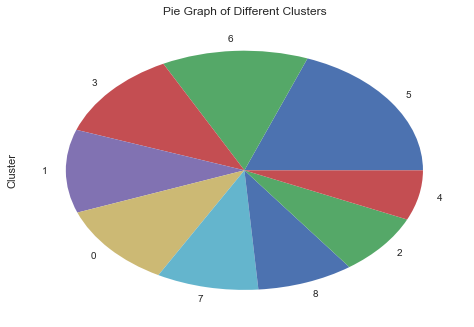

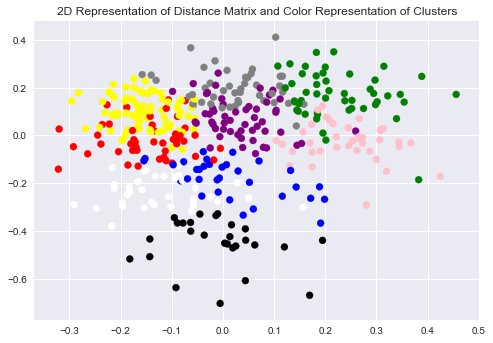

In [834]:
bball_100poss2016['Cluster'].value_counts().plot(kind = 'pie')
plt.title('Pie Graph of Different Clusters')
plt.show()
distance_map(df_dist, bball_100poss2016['Cluster'].transpose())

In [750]:
X = bball_100poss2016.ix[:, 0:21]
y = bball_100poss2016.ix[:, -1]
lr = LogisticRegression()
lr.fit(X,y)
predict = lr.predict(bball_100poss2.ix[:,0:21])
bball_100posspredict = bball_100poss2
bball_100posspredict['Cluster'] = predict
bball_100posspredict['Position'] = ''
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 0] = 'Low-Usage Forwards'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 1] = 'Low-Usage Wings'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 2] = 'Scoring Guards'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 3] = 'Defensive Bigs'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 4] = 'Elite Scoring Ballhandlers'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 5] = 'Catch-and-Shoot Wings'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 6] = 'Stretch Forwards'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 7] = 'Scoring Bigs'
bball_100posspredict['Position'].loc[bball_100posspredict['Cluster'] == 8] = 'Primary Ballhandlers'
bball_100posspredict['Position'].value_counts()

Low-Usage Forwards            1298
Catch-and-Shoot Wings          972
Defensive Bigs                 703
Scoring Guards                 695
Primary Ballhandlers           664
Scoring Bigs                   627
Stretch Forwards               586
Low-Usage Wings                471
Elite Scoring Ballhandlers     385
Name: Position, dtype: int64

In [853]:
positioncounts = []
for i in bball_100posspredict['Year'].unique():
    bball_100posstemp = bball_100posspredict.loc[bball_100posspredict['Year'] == i]
    positioncounts.append(bball_100posspredict.groupby(['Year', 'Position']).size()[i])

positioncounts = pd.DataFrame(positioncounts, index = bball_100posspredict['Year'].unique()).transpose()
positioncounts['Average'] = positioncounts.mean(axis = 1)
positioncounts

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,Average
Position,,,,,,,,,,,,,,,,,,
Catch-and-Shoot Wings,32,33,24,28,43,33,46,51,61,69,70,66,74,77,90,79,96,57.176471
Defensive Bigs,35,39,40,34,37,37,44,42,43,46,42,38,45,45,50,48,38,41.352941
Elite Scoring Ballhandlers,22,20,19,19,24,18,17,22,15,18,23,31,27,27,28,26,29,22.647059
Low-Usage Forwards,96,100,98,98,105,98,82,77,68,73,74,72,68,56,54,41,38,76.352941
Low-Usage Wings,28,23,27,27,34,29,26,25,24,15,24,27,31,28,32,42,29,27.705882
Primary Ballhandlers,42,45,37,46,41,38,44,39,43,40,36,30,42,32,42,34,33,39.058824
Scoring Bigs,48,42,38,43,36,39,27,37,31,30,40,39,40,39,38,38,22,36.882353
Scoring Guards,35,33,46,51,36,47,47,39,49,46,41,51,35,42,34,37,26,40.882353
Stretch Forwards,18,19,20,18,22,31,37,42,37,37,35,34,37,44,40,55,60,34.470588
